Patrick Yu

15 September 2023

**INTRODUCTION**



The purpose of this project is to use natural language processing (NLP) models to identify spam and ham messages and find the most common words and features that differentiate the two messages.

This dataset comes from the UCI SMS Spam Collection repository.

In this notebook, we first analyze average number of words in spam and ham messages, as well as the most common words in each class of messages.

Then, we use term frequency-inverse document frequency (TFIDF) vectorization to transform each message into TFIDF features and input the transformed dataset into SciKitLearn's Multinomial Naive Bayes classification model to generate predictions.

We also use Tensorflow Keras' GPT2 text generation large language model to rewrite the messages and use textblob's libraries to correct the spelling of each message to see if the classification can change.

**SECTION I: INSTALLING AND IMPORTING DEPENDENCIES**

In [24]:
!pip install git+https://github.com/keras-team/keras-nlp.git -q
import nltk
nltk.download('stopwords')
!pip install textblob
!pip install -q openai

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 1.8 MB/s eta 0:00:00


Importing packages

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras_nlp
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import textblob
import string
import time
import openai
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix


**SECTION II: IMPORTING DATASET**

In [26]:
#df = pd.read_csv('spam.csv')
df = pd.read_csv('spam.csv', encoding='latin-1')

df = df[['v1','v2']]
df = df.rename({'v1':'spam', 'v2':'message'}, axis = 1)
df_copy = df

df.head()

,spam,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


**SECTION III: EXPLORATORY DATA ANALYSIS**

We want to first see whether the number of words differ between spam and ham by a significant amount

In [27]:
def count_words(s):
  return len(s.split())

df['num_words'] = df['message'].apply(count_words)

df.head()

,spam,message,num_words
0,ham,"Go until jurong point, crazy.. Available only ...",20
1,ham,Ok lar... Joking wif u oni...,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28
3,ham,U dun say so early hor... U c already then say...,11
4,ham,"Nah I don't think he goes to usf, he lives aro...",13


In [28]:
print('This is the average number of words in a spam text: ' +
      str(sum(df.loc[df['spam'] == 'spam']['num_words']) /
          len(df.loc[df['spam'] == 'spam']['num_words']) ))

print('This is the average number of words in a ham text: ' +
      str(sum(df.loc[df['spam'] == 'ham']['num_words'] /
          len(df.loc[df['spam'] == 'ham']['num_words']))))

print('The variance of the number of words in spam texts are ' +
      str(np.var(df.loc[df['spam'] == 'spam']['num_words'])))

print('The variance of the number of words in ham texts are ' +
      str(np.var(df.loc[df['spam'] == 'ham']['num_words'])))

ttest_ind(df.loc[df['spam'] == 'spam']['num_words'], df.loc[df['spam'] == 'ham']['num_words'], equal_var=False)

This is the average number of words in a spam text: 23.85140562248996
This is the average number of words in a ham text: 14.200621761658054
The variance of the number of words in spam texts are 33.73293979129369
The variance of the number of words in ham texts are 130.49239339579586


TtestResult(statistic=35.89932860578407, pvalue=1.7946210484018012e-213, df=1805.5928968700903)

From the two sample t test we conducted, we see that there is evidence to suggest that spam and ham texts have a significantly different average number of words.

Interestingly, ham messages have much higher variance than spam messages. This is likely because ham messages are typically normal conversations, with varying topics, and thus can feasibly take on any length. Spam messages, conversely, are typically all about the same subject and are often written with conciseness in mind.

Next, we will generate a word cloud to show the most frequent words between spam and ham messages.

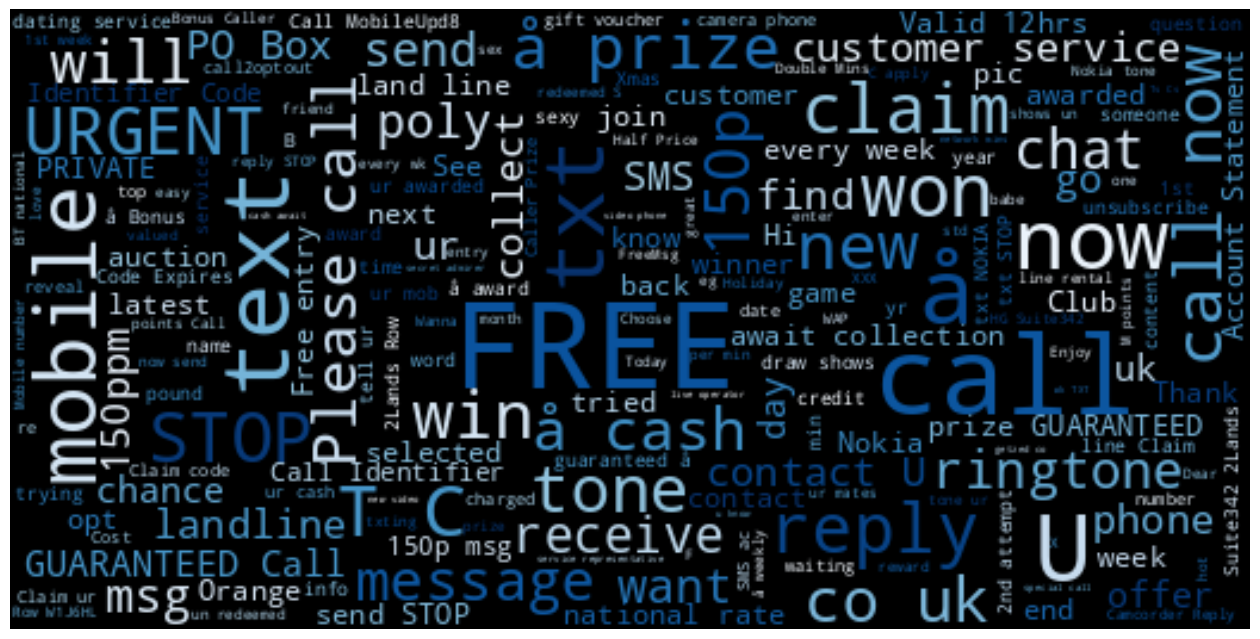

In [29]:
ham_msg = df[df['spam'] =='ham']
spam_msg = df[df['spam'] =='spam']
# Create numpy list to visualize using wordcloud
ham_msg_text = " ".join(ham_msg.message.to_numpy().tolist())
spam_msg_text = " ".join(spam_msg.message.to_numpy().tolist())\

spam_msg_cloud = WordCloud(width =520, height =260, stopwords=STOPWORDS,max_font_size=50, background_color ="black", colormap='Blues').generate(spam_msg_text)
plt.figure(figsize=(16,10))
plt.imshow(spam_msg_cloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.show()

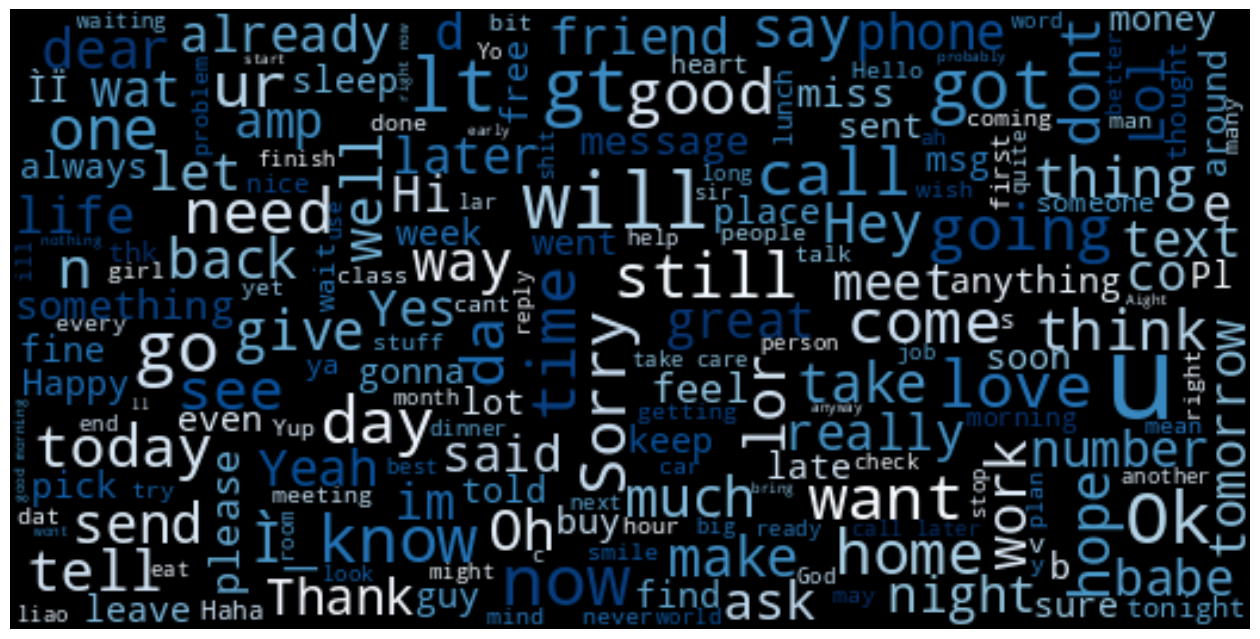

In [30]:
ham_msg_cloud = WordCloud(width =520, height =260, stopwords=STOPWORDS,max_font_size=50, background_color ="black", colormap='Blues').generate(ham_msg_text)
plt.figure(figsize=(16,10))
plt.imshow(ham_msg_cloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.show()

SECTION IV: DATA PREPROCESSING

We will preprocess the data to remove punctuation and stopwords. Stopwords are words that are commonly used ('in', 'and', etc). Punctuation can be removed for accuracy.

In [31]:
for i in range(len(df['message'].index)):
  new_text = ''
  for char in df.loc[i, 'message']:
    if char not in string.punctuation:
      new_text += char
  df.loc[i, 'message'] = new_text

for i in range(len(df.index)):
  new_msg = []
  msg = df.loc[i, 'message'].split(' ')
  for word in msg:
    if word not in stopwords.words('english'):
      new_msg.append(word)
  new_msg = ' '.join(new_msg)
  df.loc[i, 'message'] = new_msg

df.head()

,spam,message,num_words
0,ham,Go jurong point crazy Available bugis n great ...,20
1,ham,Ok lar Joking wif u oni,6
2,spam,Free entry 2 wkly comp win FA Cup final tkts 2...,28
3,ham,U dun say early hor U c already say,11
4,ham,Nah I dont think goes usf lives around though,13


SECTION V: PREDICTION

Prediction using OpenAI embeddings API
https://www.geeksforgeeks.org/spam-classification-using-openai/#


In [40]:
#openai.api_key = ""
#def get_embedding(text, model="text-embedding-ada-002"):
#   return openai.Embedding.create(input = [text], model=model)['data'][0]['embedding']

#df["embedding"] = df['message'].apply(get_embedding).apply(np.array)  # convert string to array
#df.head()

Prediction using term frequency-inverse document frequency vectorisation

In [41]:
# Splitting data for Training and testing
df['label_enc'] = df['spam'].map({'ham':0,'spam':1})
X, y = np.asanyarray(df['message']), np.asanyarray(df['label_enc'])
new_df = pd.DataFrame({'message': X, 'spam': y})
xtrain, xtest, ytrain, ytest = train_test_split(
	new_df['message'], new_df['spam'], test_size=0.2, random_state=42)
xtrain.shape, ytrain.shape, xtest.shape, ytest.shape


((4457,), (4457,), (1115,), (1115,))

In [42]:
tfidf_vec = TfidfVectorizer().fit(xtrain)
xtrain2,xtest2 = tfidf_vec.transform(xtrain),tfidf_vec.transform(xtest)

baseline_model = MultinomialNB()
baseline_model.fit(xtrain2,ytrain)

nb_accuracy = accuracy_score(ytest, baseline_model.predict(xtest2))
print('Accuracy score = ' + str(nb_accuracy))

print(classification_report(ytest, baseline_model.predict(xtest2)))

Accuracy score = 0.968609865470852
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       965
           1       1.00      0.77      0.87       150

    accuracy                           0.97      1115
   macro avg       0.98      0.88      0.93      1115
weighted avg       0.97      0.97      0.97      1115



Confusion matrix

In [45]:
confusion_matrix(ytest, baseline_model.predict(xtest2))

array([[965,   0],
       [ 35, 115]])

Falsely predicted values

In [80]:
y_predicted = baseline_model.predict(xtest2)
falsely_predicted_values = pd.concat([pd.DataFrame(xtest),pd.DataFrame(ytest),pd.DataFrame(y_predicted)], axis = 1)
#falsely_predicted_values.rename(index={0: "X_test_values", 1: "y_actual_values", 2: "y_predicted_values"})
falsely_predicted_values = falsely_predicted_values.dropna()
#falsely_predicted_values.iloc[:, [falsely_predicted_values.iloc[:,1] != falsely_predicted_values.iloc[:,2]]]
falsely_predicted_values = falsely_predicted_values[falsely_predicted_values.iloc[:,1] != falsely_predicted_values.iloc[:,2]]
falsely_predicted_values.head()

,message,spam,0
812,Congratulations ur awarded either å£500 CD gif...,1.0,0.0
683,Hi Im sue I 20 years old work lapdancer I love...,1.0,0.0
296,Unless situation YOU GO GURL would appropriate,0.0,1.0
8,WINNER As valued network customer selected rec...,1.0,0.0
809,Ugh I dont wanna get bed Its warm,0.0,1.0


Word cloud for false positives (falsely predicting spam when they are actually ham)

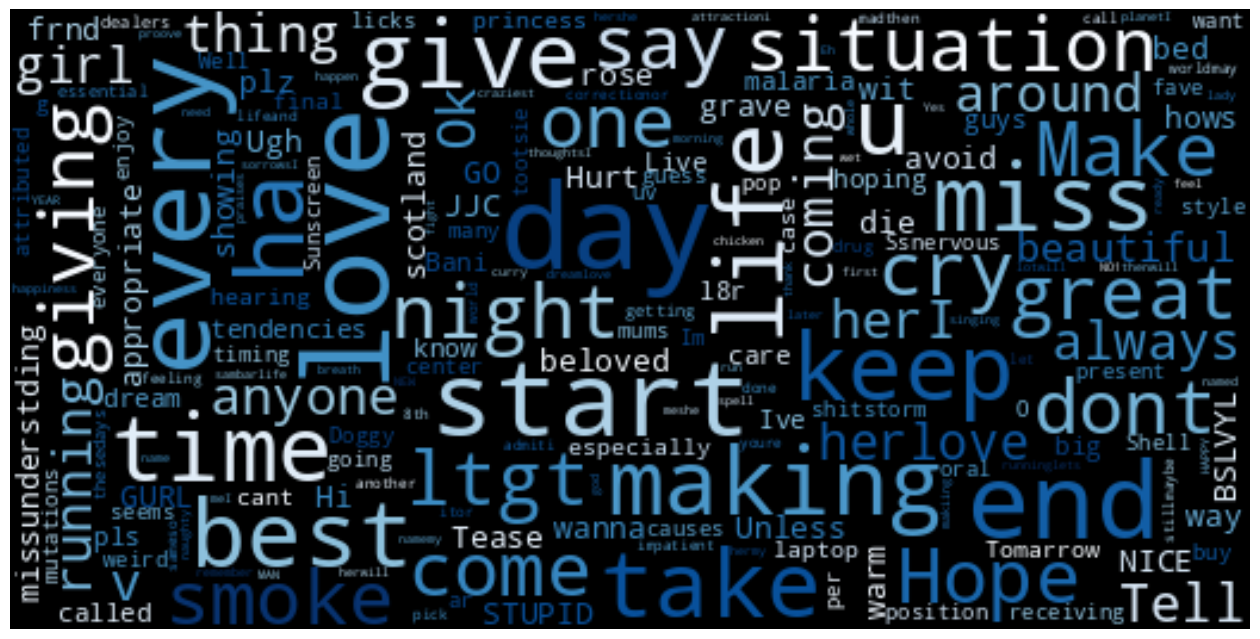

In [89]:
false_pos = falsely_predicted_values[falsely_predicted_values.iloc[:,1] == 0]
fp_text = " ".join(false_pos.message.to_numpy().tolist())
fp_cloud = WordCloud(width =520, height =260, stopwords=STOPWORDS,max_font_size=50, background_color ="black", colormap='Blues').generate(fp_text)
plt.figure(figsize=(16,10))
plt.imshow(fp_cloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.show()

Word cloud for false negatives

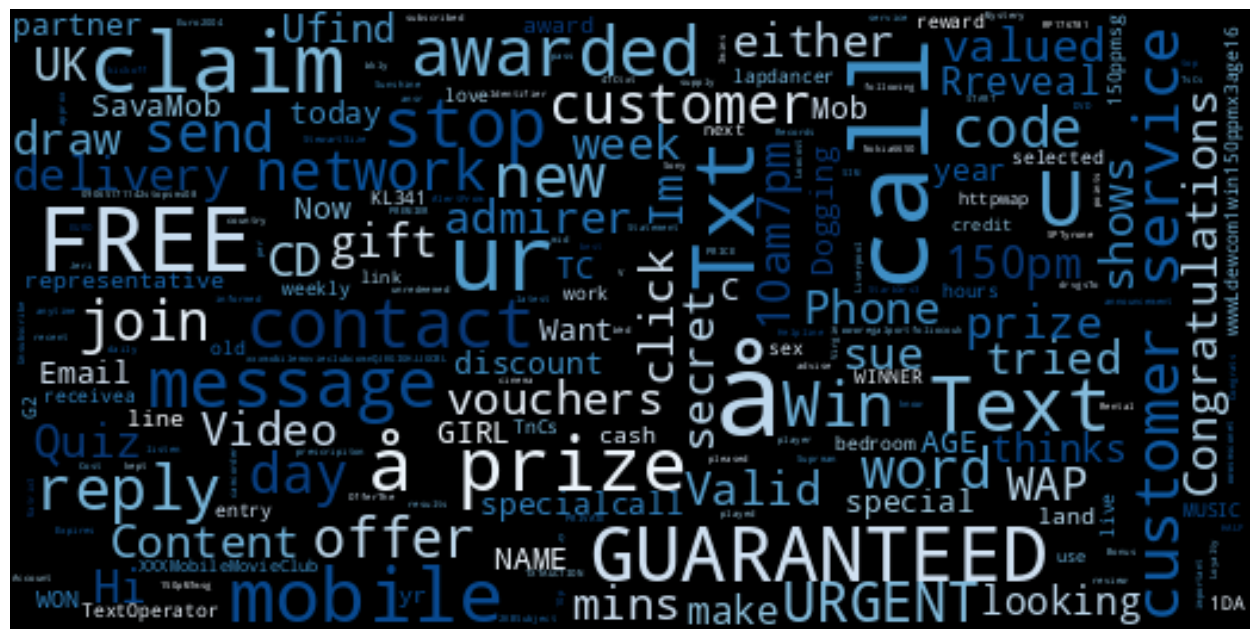

In [90]:
false_neg = falsely_predicted_values[falsely_predicted_values.iloc[:,1] == 1]
fn_text = " ".join(false_neg.message.to_numpy().tolist())
fp_cloud = WordCloud(width =520, height =260, stopwords=STOPWORDS,max_font_size=50, background_color ="black", colormap='Blues').generate(fn_text)
plt.figure(figsize=(16,10))
plt.imshow(fp_cloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.show()

Using Generative AI to rewrite messages


In [22]:
def firstFewWords(s):
  s = s.split()
  s = s[: round(len(s) * .6)]
  return " ".join(s)

df_copy['partial_message'] = df_copy['message'].apply(firstFewWords)
df_copy.head()

,spam,message,num_words,label_enc,partial_message
0,ham,Go jurong point crazy Available bugis n great ...,20,0,Go jurong point crazy Available bugis n great ...
1,ham,Ok lar Joking wif u oni,6,0,Ok lar Joking wif
2,spam,Free entry 2 wkly comp win FA Cup final tkts 2...,28,1,Free entry 2 wkly comp win FA Cup final tkts 2...
3,ham,U dun say early hor U c already say,11,0,U dun say early hor
4,ham,Nah I dont think goes usf lives around though,13,0,Nah I dont think goes


In [23]:
# To speed up training and generation, we use preprocessor of length 128
# instead of full length 1024.
preprocessor = keras_nlp.models.GPT2CausalLMPreprocessor.from_preset(
    "gpt2_base_en",
    sequence_length=128,
)
gpt2_lm = keras_nlp.models.GPT2CausalLM.from_preset(
    "gpt2_base_en", preprocessor=preprocessor
)

def generateNewMessage(s):
  return gpt2_lm.generate(s, max_length=10)

497986112/497986112 [==============================] - 5s 0us/step


In [ ]:
df_copy2 = df_copy.iloc[:10]
df_copy2['new_generated_message'] = df_copy2['partial_message'].apply(generateNewMessage)
df_copy2.head()

<ipython-input-23-c1c069ded58c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy2['new_generated_message'] = df_copy2['partial_message'].apply(generateNewMessage)


,spam,message,label_enc,partial_message,new_generated_message
0,ham,Go jurong point crazy Available bugis n great ...,0,Go jurong point crazy Available bugis n great ...,Go jurong point crazy Available bugis n
1,ham,Ok lar Joking wif u oni,0,Ok lar Joking wif,Ok lar Joking wifes a bit
2,spam,Free entry 2 wkly comp win FA Cup final tkts 2...,1,Free entry 2 wkly comp win FA Cup final tkts 2...,Free entry 2 wkly comp win FA
3,ham,U dun say early hor U c already say,0,U dun say early hor,"U dun say early horner, U dun"
4,ham,Nah I dont think goes usf lives around though,0,Nah I dont think goes,Nah I dont think goes that far.


Using Generative AI to fix the spelling of the messages

In [ ]:
def correct_spelling(word):
  return textblob.Word(word).correct()


df_copy2['corrected_gen_message'] = df_copy2['new_generated_message'].apply(correct_spelling)

<ipython-input-44-8085cf1f74e5>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy2['corrected_gen_message'] = df_copy2['new_generated_message'].apply(correct_spelling)


In [ ]:
df_copy2.head()

,spam,message,label_enc,partial_message,new_generated_message,corrected_gen_message
0,ham,Go jurong point crazy Available bugis n great ...,0,Go jurong point crazy Available bugis n great ...,Go jurong point crazy Available bugis n,Go jurong point crazy Available bugis n
1,ham,Ok lar Joking wif u oni,0,Ok lar Joking wif,Ok lar Joking wifes a bit,Ok lar Joking wifes a bit
2,spam,Free entry 2 wkly comp win FA Cup final tkts 2...,1,Free entry 2 wkly comp win FA Cup final tkts 2...,Free entry 2 wkly comp win FA,Free entry 2 wkly comp win FA
3,ham,U dun say early hor U c already say,0,U dun say early hor,"U dun say early horner, U dun","U dun say early horner, U dun"
4,ham,Nah I dont think goes usf lives around though,0,Nah I dont think goes,Nah I dont think goes that far.,Nah I dont think goes that far.
